In [70]:
import numpy as np
from tifffile import imsave

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects 
from aicssegmentation.core.pre_processing_utils import suggest_normalization_param
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice

In [56]:
filename = r"\\allen\aics\assay-dev\users\Sandi\pair-up\anthonya\fixed-cells\modifeid.tiff"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).


(188, 2, 5, 1024, 1024)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


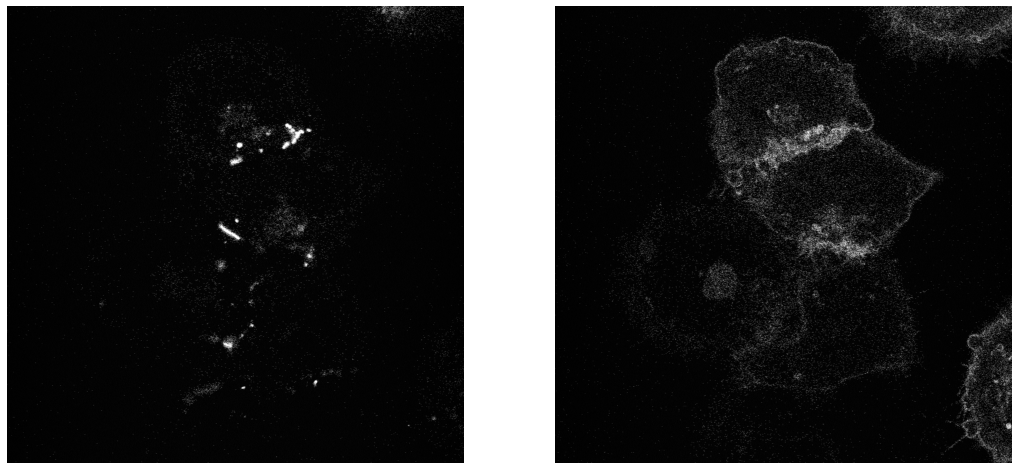

In [57]:
N_CHANNELS = IMG.shape[1] 
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [58]:
#####################
structure_channel = 0

#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()

#view(single_fluorescent_view(struct_img0))

<h3> Using Dots Playground <h3>

In [71]:
# pre-processing

intensity_scaling_param = [8000]
gaussian_smoothing_sigma = 1

# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)

# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_slice_by_slice(struct_img, sigma=gaussian_smoothing_sigma)

intensity norm: min-max norm with upper bound 8000


In [75]:
# core algorithm

## PARAMETERS for this step ##
s3_param = [[1, 0.06]] # original: [[1, 0.04]], current: [[2, 0.06]]
################################

bw = dot_3d_wrapper(structure_img_smooth, s3_param)

In [76]:
viewer_bw = view(segmentation_quick_view(bw))
# viewer_bw

In [80]:
# post-processing
minArea = 20 # current: 20 
################################

seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

In [81]:
out=seg.astype(np.uint8)
out[out>0]=255

imsave("seg-GAPfixed-10262023 SW-13 mCherry-CAAX mEmerald-Cx43-series1.tiff", out) 